<a href="https://colab.research.google.com/github/mibarguen/recommendations-at-scale/blob/main/week4_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import dcg_score, ndcg_score
from collections import OrderedDict


import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_column', None)

# **Welcome to week 4 project!**

Welcome to the last week of the course -- so excited to see that you've made it to the end! 👏 

We’ve already discussed the importance of measuring model performance. As Lord Kelvin said, “To measure is to know – If you cannot measure it, you cannot improve it.” And he was right – metrics are the only way we can actually evaluate our model’s performance!

In this week's project, we will touch upon two key aspects related to evaluation:
1. Behavioral metrics
2. Off-policy evaluation

For behavioral metrics, we will work with Spotify music sessions dataset, and implement a few behavioral metrics and understand their relationships with traditional metrics.

For off-policy evaluation, we will simulate a dataset where we have logged action policies, and see how IPS is implemented.


### Goals for this week's project:

For this week's project assignment, we will complete the following tasks:
1. Implement 3 behavioral metrics and present the correlation plot for them
2. Implement another ranking logic (e.g. sort by track popularity, or sort by danceability and compare all metrics on productional ranking logic and this new ranking logic.
3. Complete the implementation of two off-policy estimators: Capped IPS and Normalized Capped Importance Sampling (NCIS)


# Part A: Behavioral metrics

Behavioral metrics include factors like what items a user interacts with and how, the amount of time they spend on the platform, and how they spend that time.

To define and implement a few behavioral metrics, we will work with the Spotify music sessions dataset.
Download the dataset from GDrive: https://drive.google.com/drive/folders/10LGZMgXRuz2qPr_QDbYdVVlKEcnQ25YL?usp=sharing
(files: log_mini.cvs and tf_mini.csv)

## Spotify music sessions dataset

The public part of the dataset consists of roughly 130 million listening sessions with associated user interactions on the Spotify service. In total, users interacted with almost 4 million tracks during these sessions, and the dataset includes acoustic features and metadata for all of these tracks.

Detailed description of the dataset can be found here:
https://drive.google.com/file/d/1BELTuH4nBeyHna5EAGzJv-HWHKrbxPsf/view?usp=sharing



In [2]:
log = pd.read_csv("../data/log_mini.csv")
tracks = pd.read_csv("../data/tf_mini.csv")

In [4]:
tracks.head(2)

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.02858,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.12386,0.746904,0.371803,-0.420558,-0.213120,-0.525795


### Traditional metrics: ndcg@k

We will use the log dataframe as the main dataframe for evaluation of metrics. The skip_1 flag can be used as a relevance signal -- if the user found the recommendation relevant, skip_1 = False. With this relevance signal, we can compute simple ndcg metrics -- one for each session and then averaged across all sessions. This will serve as a base metric for comparison.

Note: the ranking logic here is assumed to be the production ranker, i.e. sorting by session_position gives the exact order of tracks the Spotify ranker presented to the user.

Lets compute simple skip rate and ndcg metric for the production ranker:

In [6]:
topk = 10

skip_rate_session = log.groupby('session_id').apply(lambda x: x.nsmallest(topk,['session_position'])).reset_index(drop=True).groupby("session_id").skip_1.mean().mean()
print("average skip rate in the session: ",skip_rate_session)


average skip rate in the session:  0.40893999999999464


In [7]:
topk = 10

def get_ndcg(df):
    true_relevance = np.asarray(1-np.asarray(df['skip_1']*1.0))
    ranker_scores = np.asarray(1/np.asarray(df['session_position'])) # approximate the ranker scores using the session position
    return(ndcg_score([true_relevance], [ranker_scores]))


ndcg_metric = log.groupby('session_id').apply(lambda x: x.nsmallest(topk,['session_position'])).reset_index(drop = True).groupby("session_id").apply(get_ndcg).mean()
print("NDCG@k, with k= ",
      topk," is: ",ndcg_metric)



NDCG@k, with k=  10  is:  0.8330266041453124


In [101]:
ndcg_metric = log.groupby('session_id').apply(lambda x: x.nsmallest(5,['session_position'])).reset_index(drop = True).groupby("session_id").apply(get_ndcg).mean()
print("NDCG@k, with k= ",
      topk," is: ",ndcg_metric)



NDCG@k, with k=  10  is:  0.8235700606177426


## Goals for this week:

Implement a few behavioral metrics and compare their correlations. We will implement the following three metrics:
1. *Time to first skip:* how long did it take for the user to get the first bad recommendation, i.e. a recommendation they skipped. Since we can't easily calculate time, we can use number of songs as a proxy and compute the metric as number of songs it took for the first skip.

2. *Sustained dissatisfaction:* we assume that the user is dissatisfied in a sustained manner if they skip 3 songs consecutively.

3. *Session coherence:* we define coherence as how similar the recommended musical tracks are. We can use the acoustic_vector of the music tracks to calculate the similarity.

### Time to first skip

In [84]:
def get_time_to_first_skip(df):
    skipped_tracks = df['skip_1'] == True
    df.loc[skipped_tracks, 'session_track_num'] = df.loc[skipped_tracks].sort_values(by='session_position').groupby('session_id')['track_id_clean'].cumcount()
    df['first_skip'] = df['session_track_num'] == 0
    
    df_first_skip = df[df['first_skip'] == True]
    
    ### Users who never skipped
    users_never_skipped = set(df['session_id'].unique()) - set(df_first_skip['session_id'])
    
    ### What was the last session-track-number that users who never skipped heard?
    users_never_skipped_df = df[df['session_id'].isin(users_never_skipped)]
    users_never_skipped_df = users_never_skipped_df.groupby('session_id')['session_position'].max().reset_index()
    
    
    df_first_skip.rename({'session_position': 'last_track_num'}, axis=1, inplace=True)
    df_first_skip['observed_first_skip'] = True
    
    users_never_skipped_df.rename({'session_position': 'last_track_num'}, axis=1,inplace=True)
    users_never_skipped_df['observed_first_skip'] = False
    
    cols = ['session_id', 'last_track_num', 'observed_first_skip']
    
    return pd.concat([df_first_skip[cols], users_never_skipped_df[cols]])
    
    

In [85]:
df = get_time_to_first_skip(log)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-84-cfae5b7e92ab>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_skip['observed_first_skip'] = True


In [86]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df['last_track_num'], event_observed=df['observed_first_skip'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 10000 total observations, 577 right-censored observations>

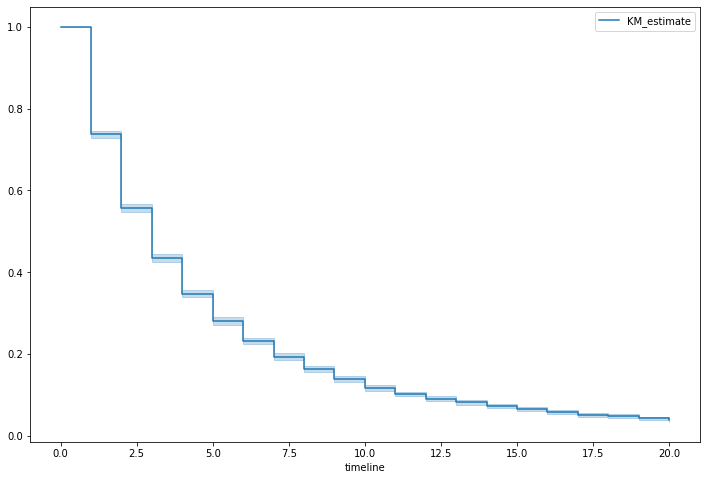

In [88]:
fig, ax = plt.subplots(figsize=(12, 8))
kmf.plot()
plt.show();

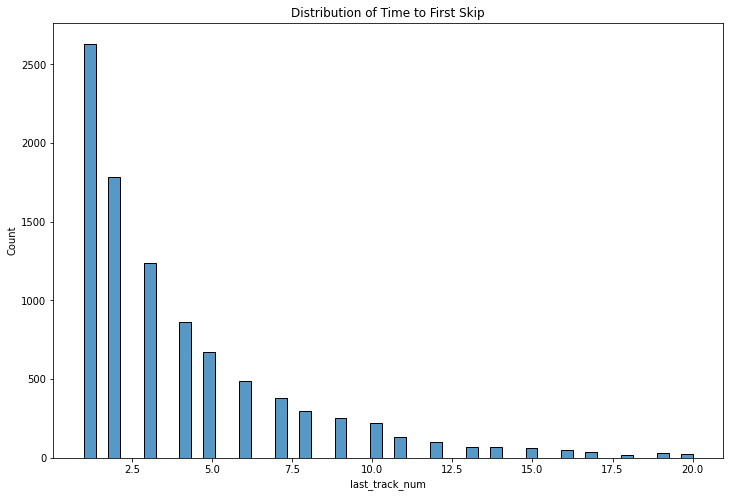

In [90]:
observed_skip_df = df[df['observed_first_skip'] == True]


fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(observed_skip_df['last_track_num'])
ax.set_title('Distribution of Time to First Skip')
plt.show();

In [96]:
time_to_first_skip.mean()

0.0

In [97]:
print(f'Average time to first skip: {round(observed_skip_df["last_track_num"].mean(), 3)}')



Average time to first skip: 3.975


In [61]:
# implement session metric 1: time to first skip (number of songs to first skip)

time_to_first_skip =  get_time_to_first_skip(log)
print(round(time_to_first_skip['session_position'].mean(), 3))



3.975


### implement session metric 2: sustained dissatisfaction: proportions of sessions with 3 consecutive skips


In [115]:
# implement session metric 2: sustained dissatisfaction: proportions of sessions with 3 consecutive skips
log['lag_skip_1'] = log.groupby('session_id')['skip_1'].shift(-1)
log['lead_skip_1'] = log.groupby('session_id')['skip_1'].shift(1)

sustained_dissatisfaction_users = log[(log['skip_1'] == 1) &
                                     (log['lag_skip_1'] == 1) &
                                     (log['lead_skip_1'] == 1)]

sustained_dissatisfaction_users['session_id'].nunique() / log['session_id'].nunique()


0.6543

### implement session metric 3: session coherence: average similarity between the top recommended tracks


In [123]:
acoustic_vector_cols = [f'acoustic_vector_{i}' for i in range(8)]
simple_tracks_df = tracks[['track_id'] + acoustic_vector_cols]

joined_df = pd.merge(log, simple_tracks_df, 
                     left_on='track_id_clean',
                     right_on='track_id',
                     how='left')




Once these metrics are implemented, compute these metrics for topk=5 and topk=10 compare their estimates for the production ranker as a correlation plot. Please note which metrics are correlated with ndcg metric.

**Additional goal:**
Implement another simple ranking logic, and compare the performance of both the production ranker and new ranking policy on the ndcg and three behavioral metrics.
A simple ranking policy could include sortby track popularity, or sort by danceability score for the track.

Please report the performance of these rankers on all four metrics.

# Part B: Off Policy Evaluation

We log listener behavior based on the recommendations that the production recommender serves to the listener. Using this data to assess any new recommender system, however, can present challenges – the production recommender and the new recommender can drastically differ in the results that they display to the user. For example, maybe the new recommender presents a lot of niche content, while the production recommender presents a lot of popular options. This can be an issue when evaluating a new recommender – If you don’t have any feedback on a recommendation because you never presented it to a user, how can you evaluate whether it’s a good recommendation?
If you have a new policy to test that’s very similar to your old approach, then this won’t be an issue, and it’ll be easy to test! However, if the policy is very different, then you’ll need to collect special logged data.

In this part of the project, we will simulate a recommendation policy and leverage counterfactual estimators as metrics to compare performance.


Lets first begin by generating a few users and products. For ease of simulation, we assume users derive equal satisfaction from each item.

In [125]:

users = np.array(["user1", "user2", "user3"])
products = np.array(
    [
        "product_a",
        "product_b",
        "product_c",
        "product_d",
        "product_e",
        "product_f",
        "product_g",
    ]
)

satisfaction = {
    "product_a": 100,
    "product_b": 150,
    "product_c": 100,
    "product_d": 200,
    "product_e": 500,
    "product_f": 120,
    "product_g": 160,
}



Lets also implement whether a given user will accept a given recommendation or not. Once done, we can implement a target policy that makes recommendations.

In [126]:

def will_purchase(user, product):
    if user == "user1" and (
        product == "product_a" or product == "product_b" or product == "product_c"
    ):
        return True
    elif user == "user2" and (product == "product_d" or product == "product_e"):
        return True
    elif user == "user3" and (product == "product_f" or product == "product_g"):
        return True
    else:
        return False


def choose_user():
    return np.random.choice(users, size=1)


def logging_policy():
    return np.random.choice(products, size=1), 1 / len(products)


class TargetPolicy:
    def __init__(self):
        self.user_probs = {
            "user1": np.array([0.1, 0.1, 0.2, 0.1, 0.15, 0.15, 0.20]),
            "user2": np.array([0.1, 0.10, 0.05, 0.25, 0.3, 0.1, 0.1]),
            "user3": np.array([0.06, 0.06, 0.3, 0.06, 0.06, 0.4, 0.06]),
        }

        for user, probs in self.user_probs.items():
            assert probs.sum() == 1
            assert len(probs) == len(products)

    def recommend(self, user):
        user_prob = self.user_probs[user]
        product = np.random.choice(products, size=1, p=user_prob)
        product_idx = np.where(products == product)
        prob = user_prob[product_idx]

        return product, prob

    def get_prob(self, user, product):
        user_prob = self.user_probs[user]
        product_idx = np.where(products == product)
        product_prob = user_prob[product_idx]

        return product_prob



Having defined all key components of the dataset generation, lets create logged data that we can finally use for evaluation purposes:

In [127]:
def compute_satisfaction(user, product):
    if will_purchase(user, product):
        return satisfaction[product.item()]
    else:
        return 0


def create_logs(n=1000):
    logs = []
    target_policy = TargetPolicy()

    for _ in range(n):
        user = choose_user()

        logging_product, logging_prob = logging_policy()
        model_prob = target_policy.get_prob(user.item(), logging_product)

        target_product, _ = target_policy.recommend(user.item())

        logging_satisfaction = compute_satisfaction(user, logging_product)
        target_satisfaction = compute_satisfaction(user, target_product)

        log = OrderedDict(
            {
                "user_features": user.item(),
                "item_placed": logging_product.item(),
                "item_prob": logging_prob,
                "item_satisfaction": logging_satisfaction,
                "model_prob": model_prob.item(),
                "ab_test_satisfaction": target_satisfaction,
            }
        )

        logs.append(log)

    return pd.DataFrame(logs)

Here is what ur logged data now looks like:

In [129]:
logs = create_logs(n=1000)
logs.head(5)

,user_features,item_placed,item_prob,item_satisfaction,model_prob,ab_test_satisfaction
0,user2,product_c,0.142857,0,0.05,0
1,user2,product_c,0.142857,0,0.05,200
2,user1,product_b,0.142857,150,0.10,0
3,user3,product_e,0.142857,0,0.06,0
4,user2,product_a,0.142857,0,0.10,0


In [130]:
logs[["user_features", "item_placed", "item_prob", "item_satisfaction"]].sample(n=10)

,user_features,item_placed,item_prob,item_satisfaction
552,user3,product_d,0.142857,0
497,user2,product_g,0.142857,0
187,user3,product_d,0.142857,0
293,user2,product_d,0.142857,200
583,user2,product_g,0.142857,0
914,user3,product_g,0.142857,160
197,user3,product_a,0.142857,0
831,user2,product_c,0.142857,0
469,user1,product_d,0.142857,0
680,user2,product_a,0.142857,0


With all the dataset ready, lets compute the mean rewards (satisfaction) for the logging/production policy and the target policy:

In [131]:
%%time
sim = create_logs(n=100000)
logging_policy = sim["item_satisfaction"].mean()
target_policy = sim["ab_test_satisfaction"].mean()

print(f"Expected reward from logging policy: {logging_policy: .2f}")
print(f"Expected reward from target policy: {target_policy: .2f}")

Expected reward from logging policy:  63.01
Expected reward from target policy:  100.64
CPU times: user 8.25 s, sys: 110 ms, total: 8.36 s
Wall time: 8.39 s


Now lets implement the IPS estimator:

In [134]:
def compute_ips(df):
    assert {"model_prob", "item_prob", "item_satisfaction"}.issubset(df.columns)
    return ((df["model_prob"] / df["item_prob"] )* df["item_satisfaction"]).mean()



In [135]:
ips_est = compute_ips(logs)
ips_est

91.14419999999991

Computing the IPS estimator on our 1,000 entry log gives an average revenue of 109.34 (very close to the true performance of 100.99) compared with the average revenue of the logging policy of 63.36. Therefore, we should be confident to deploy our target policy to production and do an AB test comparing it with the logging policy as a final validation.

## Goals for this part of project:

Finish the implementation of two additional off-policy estimators:
1. Capped IPS
2. Normalized Capped Importance Sampling (NCIS)

Feel free to try different capping thresholds, and compare the reward and standard deviations of these estimators with the IPS estimator and mean reward.


In [142]:
def compute_capped_ips(logs, cap=1000):
    ips = ((logs['model_prob'] / logs['item_prob']) * logs['item_satisfaction'])
    return ips.apply(lambda x: min(x, cap)).mean()





In [145]:
def compute_ncis(logs, cap=1000):
    denom = (logs['model_prob'] / logs['item_prob']).apply(lambda x: min(x, cap)).mean()

    return compute_capped_ips(logs, cap) / denom



In [148]:
compute_ncis(logs, 10)

3.415769984305924